In [1]:
# Librerías necesarias para el estudio
import pandas as pd
import networkx as nx 
import numpy as np
import os.path
import matplotlib.pyplot as plt
import math
import seaborn as sns
from statsmodels.stats.multitest import multipletests
from scipy.stats import ttest_ind, mannwhitneyu, shapiro, chi2_contingency
from tabulate import tabulate
from itertools import combinations
from sklearn import metrics, svm, linear_model
from sklearn.model_selection import train_test_split
from neuroCombat import neuroCombat
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from collections import Counter
from combat.pycombat import pycombat
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score

# 1. Importación de datos

En esta sección, procedemos a importar los diferentes ficheros que son necesarios para el presente estudio. Estos son:
- *mindboggle_ROIs.txt* - Nombre de las diferentes regiones del cerebro y su correspondiente orden de aparición en las matrices de conectividad
- *clinic.csv* - Datos clínicos de los sujetos que participan en el estudio
- *XXXX_FA_factor.csv* - Matriz de conectividad estructural del sujeto XXX
- *XXXX_GM_matrix.csv* - Matriz de conectividad morfológica del sujeto XXXX
- *XXXX_r_matrix.csv* - Matriz de conectividad funcional del sujeto XXXX


In [2]:
# Listado de regiones cerebrales (en su respectivo orden de aparición en las matrices de conectividad)
nodes = pd.read_csv('Datasets/mindboggle_ROIs.txt', sep='\t')["[ sROI_MINDBOGGLE]"].to_list()
num_nodes = len(nodes)
edges = [tuple(sorted(c, key=str.casefold)) for c in combinations(nodes,2) if c[0]!=[1]]

# Listado de variables que tendremos en cuenta (posiciones [i,j] de la diagonal superior de las matrices)
variables = []
for i in range(0,num_nodes):
    for j in range(i+1,num_nodes):
        variables.append((i,j))

# Datos clínicos de los sujetos
clinic = pd.read_csv('Datasets/clinic.csv')

# Modificamos el datatype de la variable 'sex' para que sea categórica
clinic['sex'] = clinic['sex'].astype('category')

# Listado de identificadores de cada uno de los grupos (pacientes/controles)
patients = dict.fromkeys(clinic[clinic.controls_ms==1]['id'].to_list())
controls = dict.fromkeys(clinic[clinic.controls_ms==0]['id'].to_list())

# Matrices de conectividad de cada uno de los sujetos 
def import_connectivity_matrix(subjects):
    '''
    Dada una lista de IDs, esta función retorna
    las matrices FA, GM y rfMRI para cada uno de ellos
    en formato diccionario {ID : {FA: [], GM: [], rfMRI: []}}
    '''
    for s in subjects:
        subjects[s]               = dict.fromkeys(['FA','GM','rfMRI'])
        subjects[s]['FA']         = pd.read_csv('Datasets/subject_networks_FA_v1/'       + s +'_FA_factor.csv', header=None)
        subjects[s]['GM']         = pd.read_csv('Datasets/subject_networks_GM_v1-no-thr/'+ s +'_GM_matrix.csv', header=None)
        subjects[s]['rfMRI']      = pd.read_csv('Datasets/subject_networks_rfMRI_v1/'    + s +'_r_matrix.csv' , header=None)
        subjects[s]['zAttention'] = list(clinic[clinic.id == s]['zattention'])[0]

        
import_connectivity_matrix(patients)
import_connectivity_matrix(controls)

In [3]:
print("Número de sujetos: {}".format(len(patients)+len(controls)))
print("Número de regiones cerebrales: {}".format(len(nodes)))
print("Número de conexiones cerebrales: {}".format(len(edges)))

Número de sujetos: 165
Número de regiones cerebrales: 76
Número de conexiones cerebrales: 2850


# 2. Preprocesamiento de datos

Dadas *m* matrices de conectividad (estructural, morfológica o funcional) de tamaño *nxn*, en este estudio – dada la naturaleza simétrica de estas matrices – únicamente consideraremos los valores de la diagonal superior de cada una de ellas. Esto resulta en un total de n(n-1)/2 variables de longitud *m*.

Para cada variable *y*, con el fin de minimizar los factores de confusión, llevaremos a cabo los ajustes descritos en los siguientes apartados.


## 2.1. Correción por edad y sexo

Realizaremos una corrección por edad y sexo usando una regresión lineal para tener en cuenta la variabilidad debido a estos factores. Aplica a todas las matrices (estructurales, morfológicas y funcionales)

Para ello, para cada variable *y*:

1.	Construimos un modelo de regresión y – edad + género
2.	Guardamos los residuos (representan la información no explicada por las variables independientes)
3.	Sumamos a estos residuos la media de y obtenida únicamente considerando los sujetos control
4.	Reemplazamos los valores actuales por los obtenidos en el paso anterior

In [4]:
# Variable para almacenar el valor medio de cada variable (i,j) solo para los controles
control_means = dict.fromkeys(['FA','GM','rfMRI'])

for t in ['FA','GM','rfMRI']:
    control_means[t] = {} 
    
    for (i,j) in variables: 
        
        # Calculamos, para cada variable [i,j], la media de los valores de los sujetos control (solo diagonal superior)
        control_means[t][(i,j)] = np.mean([controls[s][t][i][j] for s in controls])        
    
        # De cada sujeto, recuperamos el sexo, la edad y el valor real de la variable
        subjects = []
        age = []
        gender = []
        real_values = []
        
        for group in [controls,patients]:
            for s in group:
                subjects.append(s)
                age.append(list(clinic[clinic.id==s]['age'])[0])  
                gender.append(list(clinic[clinic.id==s]['sex'])[0])               
                real_values.append(group[s][t][i][j])
                
        # Ajustamos los valores a una regresión lineal en función de la edad y el sexo
        x = [age,gender]; x = np.array(x).T
        y = real_values; y = np.array(y)
        new_values = linear_model.LinearRegression().fit(x,y).predict(x)
        
        # Reemplazamos el valor actual por el nuevo valor
        for group in [controls,patients]:
            for s in group: 
                    k = subjects.index(s)
                    group[s][t][i][j]=real_values[k]-new_values[k]+control_means[t][(i,j)]

## 2.2. Normalización de datos

Normalizamos los datos para tenerlos en un rango de [0,1]. Aplica a todas las matrices (estructurales, morfológicas y funcionales) 

Para ello, para cada una de las variables *y*,

1.	Obtenemos una lista con los valores actuales de la variable
2.	Normalizamos la lista con MinMaxScaler(feature_range=(0, 1))  
3.	Reemplazamos los valores actuales por los valores normalizados


In [5]:
scaler = MinMaxScaler(feature_range=(0, 1))

# Normalizamos cada una de las variables
for t in ['FA','GM','rfMRI']:
    for (i,j) in variables:
        
        # De cada sujeto, recuperamos el valor real de la variable
        subjects = []
        real_values = []
        
        for group in [controls,patients]:
            for s in group:
                subjects.append(s)               
                real_values.append(group[s][t][i][j])
        
        # Normalizamos
        new_values = scaler.fit_transform(np.array(real_values).reshape(-1, 1))    
        
        # Reemplazamos el valor actual por el nuevo valor
        for group in [controls,patients]:
            for s in group: 
                k = subjects.index(s)
                group[s][t][i][j]=new_values[k]

## 2.3. Harmonización de pesos

Las matrices de conectividad estructural podrían sufrir variabilidad entre sitios debido a la heterogeneidad de ambos protocolos de adquisición (MVIS y FIS). Por ello, será necesario harmonizar los pesos. Solo aplica a matrices de conectividad estructural.

Para ello, 

1.	Obtenemos un listado vals de todos los valores actuales
2.	Generamos un listado batch que distinga (con los valores 1 y 2) los sites que se han empleado para la obtención de cada uno de los valores de la lista anterior 
3.	Calculamos los valores harmonizados de vals con la función pycombat utilizando la distinción batch
4.	Reemplazamos los valores actuales por los valores harmonizados


In [6]:
from combat.pycombat import pycombat

for t in ['FA']:
    
    subject_values = []
    sites = []
    real_values = []
    
    for group in [controls,patients]:
        for s in group:
            for (i,j) in variables: 
                subject_values.append((s,i,j))
                sites.append(1 if 'MSVIS' in s else 2)               
                real_values.append(group[s][t][i][j])   
    
                
    # Harmonización de pesos
    data = pd.DataFrame(np.array(real_values).T).T
    batch = sites
    new_values = pycombat(data,batch,mean_only=True).T
    new_values = new_values.T
    
    # Reemplazamos el valor actual por el nuevo valor
    for group in [controls,patients]:
        for s in group:
            for (i,j) in variables:
                k = subject_values.index((s,i,j))
                group[s][t][i][j]=new_values[k]

Using mean only version
Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_15960/1797645706.py:28: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  group[s][t][i][j]=new_values[k]


## 2.4. Valores nulos 

En esta sección, procedemos al tratado de valores nulos. 

Para ello, cada valor nulo que aparezca para una variable *y* se reemplazará por la media de los valores de la variable.

In [7]:
ij_means= {}

for t in ['FA','GM','rfMRI']:
    
    ij_means[t] = {} 
    
    for (i,j) in variables: 
        
        # Calculamos, para cada variable [i,j], la media de los valores de todos los sujetos
        ij_means[t][(i,j)] = np.mean([controls[s][t][i][j] for s in controls if np.isnan(controls[s][t][i][j])==False] \
                                     +[patients[s][t][i][j] for s in patients if np.isnan(patients[s][t][i][j])==False])
        
        # Reemplazamos los valores nulos por la media de los valores
        for group in [controls,patients]:
            for s in group:
                if(np.isnan(group[s][t][i][j])==True):
                    group[s][t][i][j] = ij_means[t][(i,j)]                             

## 2.5. Aplicación de umbrales y filtrado de conexiones

Con el objetivo de minimizar la presencia de falsas conexiones, solo contemplaremos en el análisis aquellas conexiones que, tras todo el preprocesamiento anterior,

- tengan un peso mínimo de 0.1
- estén presentes en más del 60% de los sujetos sanos 

Las conexiones que no cumplen estas condiciones se reemplazan por el valor 0 para ser posteriormente descartadas.

In [8]:
# eliminamos cualquier conectividad <0.1 (las ponemos a cero) 
for group in [patients, controls]:
    for s in group:
        for matrix in ['FA','GM','rfMRI']:
            for (i,j) in variables:
                if group[s][matrix][i][j] < 0.1: #or np.isnan(group[s][matrix][i][j]) == True:
                    group[s][matrix][i][j] = 0

In [9]:
counter = {}

# Calculamos, para cada variable, el número de sujetos controles en las que se encuentra presente
for (i,j) in variables: 
    counter[(i,j)] =0
    for s in controls:
        if controls[s]['FA'][i][j]!=0: 
            counter[(i,j)] = counter[(i,j)] + 1

# conexiones que aparecen en más del 60% de los controles
conexiones = [c for c in counter if counter[c]/len(controls)>=0.6]
print(len(conexiones))

# Eliminamos aquellas que no se encuentran en el listado anterior
for group in [patients, controls]:
    for s in group:
        for matrix in ['FA','GM','rfMRI']:
            for (i,j) in variables:
                if (i,j) not in conexiones:
                    group[s][matrix][i][j] = 0

1933


# 3. Estudio de los datos clínicos y demográficos

En este apartado llevamos a cabo un pequeño estudio de los datos demográficos de los sujetos y verificamos si existen diferencias significativas entre los dos grupos (pacientes/controles) para las variables comunes.

In [10]:
def mean_std(col,new_label,only_ms=0):
    '''
    Function that returns an array with four elements:
        - new_label
        - mean+std for patients
        - mean+std for controls (only if only_ms=0)
        - Student t-test p-value (only if only_ms=0)
    '''
    variable = [new_label]
    col_patients = clinic[clinic.controls_ms == 1][col]
        
    # [mean, std] for MS patients
    variable.append(col_patients.agg(['mean','std']).round(2).to_list())
    
    if only_ms == 0: 
        
        # [mean, std] for controls
        col_controls = clinic[clinic.controls_ms == 0][col]
        variable.append(col_controls.agg(['mean','std']).round(2).to_list())
        
        # Student t-test
        variable.append(mannwhitneyu(col_patients.to_list(),
                                  col_controls.to_list())
                        .pvalue)
    else:
        variable.append("n/a")
        variable.append("n/a")

    return variable


def count_pct(col,new_label):
    variable = [new_label]
    
    col_patients = list(clinic[clinic.controls_ms == 1][col])
    col_controls = list(clinic[clinic.controls_ms == 0][col])
        
    # [mean, std] for MS patients
    counts = Counter(col_patients)
    variable.append([counts[0],round(counts[0]/(counts[0]+counts[1])*100,2)])    
    
    # [mean, std] for MS controls
    counts = Counter(col_controls)
    variable.append([counts[0],round(counts[0]/(counts[0]+counts[1])*100,2)])  
    
    # test
    pvalue = chi2_contingency([list(Counter(col_patients).values()),
                               list(Counter(col_controls).values())])[1]
    variable.append(pvalue)
    
    return variable
    
data = []
data.append(mean_std('age','Age'))
data.append(count_pct('sex','Sex (F, %)'))
data.append(mean_std('dd','Disease duration',only_ms=1))
data.append(mean_std('zpasat','zPASAT score',only_ms=1))
data.append(mean_std('sdmtz','zSDMT score',only_ms=1))
data.append(mean_std('zattention','zAttention score',only_ms=1))


print (tabulate(data, headers=["Variable", "MS Patients", "Controls", "p-valor"]))

Variable          MS Patients     Controls      p-valor
----------------  --------------  ------------  ----------------------
Age               [47.33, 10.15]  [36.62, 9.6]  0.00017663447852410628
Sex (F, %)        [104, 70.75]    [15, 83.33]   0.39784392998317575
Disease duration  [15.96, 9.05]   n/a           n/a
zPASAT score      [-0.29, 1.33]   n/a           n/a
zSDMT score       [0.08, 1.06]    n/a           n/a
zAttention score  [-0.29, 1.04]   n/a           n/a


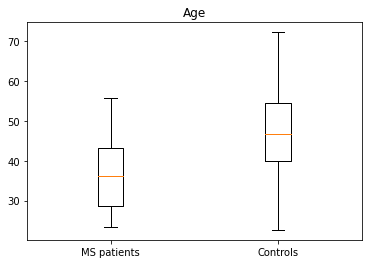

In [11]:
plt.boxplot([clinic[clinic.controls_ms == 0]['age'],clinic[clinic.controls_ms == 1]['age']])
plt.xticks([1,2],['MS patients','Controls'])
plt.title('Age')
plt.show()

Observamos que los grupos presentan diferencias significativas en lo que respecta a la edad.

# 4. Cálculo de métricas de grafos

## 4.1. Transformación a grafos

En esta sección, se transforman las diferentes matrices de conectividad en objetos de tipo grafo donde

- cada nodo se corresponde con una región cerebral
- se genera un enlace entre dos nodos si la correspondiente conectividad es diferente de 0
- el peso del enlace se corresponde con el valor de la conectividad


In [16]:
def sym_matrix_to_graph (data, nodes):
    """
    Dada una matriz simetrica 'data' donde v[i,j] es el valor de la posición [i,j],
    se retorna un grafo con aristas [i,j], con nombre de los nodos nodes[i] y nodes[j], 
    y peso de la arista v[i,j]
    """
    # Declaramos la lista donde se almacenarán los diferentes pares de aristas y pesos
    weighted_edges = []

    # Calculamos las aristas y sus correspondientes pesos
    for (i,j) in variables:
        # no consideramos aristas aquellas conectividades que son 0
        if data[i][j]!=0: # and pd.isna(data[i][j])==False:
            weighted_edges.append((nodes[i], nodes[j],data[i][j]))

    # Generamos el grafo correspondiente
    G = nx.Graph()
    G.add_weighted_edges_from(weighted_edges)
    
    # Retornamos el grafo
    return G


def connectivity_graphs(subjects, nodes):
    '''
    Dado un diccionario {ID : {FA: [], GM: [], rfMRI: []}}, donde los [] corresponden
    a datasets, esta función aplica sym_matrix_to_graph() function a cada dataset
    '''
    for s in subjects.keys():
        subjects[s]['FA']    = sym_matrix_to_graph(subjects[s]['FA'],nodes)
        subjects[s]['GM']    = sym_matrix_to_graph(subjects[s]['GM'],nodes)
        subjects[s]['rfMRI'] = sym_matrix_to_graph(subjects[s]['rfMRI'],nodes)
        
connectivity_graphs(patients,nodes)
connectivity_graphs(controls,nodes)

## 4.2. Métricas globales

En este apartado, se calcula para cada uno de los grafos (tanto estructurales, morfológicos, como funcionales) las siguientes métricas:

- strength - suma de los grados (ponderados por peso)
- transitivity - ratio de triangulos
- global efficiency - media de la inversa de los caminos más cortos entre pares de nodos 
- assortativity - coeficiente de correlación entre los grados (ponderados por peso) de todos los nodos en dos extremos opuestos de un enlace 
- path length - media de las longitudes de los caminos más cortos entre pares de nodos 
- betweenness centrality - media de la fracción de todos los pares de caminos más cortos que pasan a través de un nodo 

Una vez calculadas las métricas, se procede a comparar cada una de ellas entre los sujetos pacientes y los sujetos control, para ver si existen diferencias significativas entre ambos grupos. Para ello, empleamos el test U de Mann-Whitney con corrección de Bonferroni.

In [17]:
def graph_global_metrics(graph_list):
    '''
    Dada una lista de grafos, esta función retorna, para cada uno de ellos las siguientes
    métricas: strength, transitivity, global efficiency, assortativity, clustering coefficient,
    betwenness centrality
    '''
    cmetrics = {}
    
    # Cálculo de métricas
    cmetrics['Strength']                         = [np.sum([w[1] for w in list(G.degree(weight='weight'))])
                                                   for G in graph_list]
    cmetrics['Transitivity']                     = [nx.transitivity(G) for G in graph_list]
    cmetrics['Global efficiency']                = [nx.global_efficiency(G,) for G in graph_list]
    cmetrics['Assortativity']                    = [nx.degree_pearson_correlation_coefficient(G,weight='weight') 
                                                   for G in graph_list]
    cmetrics['Path length']                      = [nx.average_shortest_path_length(G) for G in graph_list]
    cmetrics['Betweenness centrality']           = [np.mean(list(nx.betweenness_centrality(G,weight='weight').values())) 
                                                   for G in graph_list]
    # Retornamos los resultados
    return cmetrics


def global_metrics_summary(patients_metrics,controls_metrics, metrics, alternative='two-sided'):
    '''
    Retorna una tabla con el resumen de las métricas para ambos grupos de sujetos
    y el pvalor correspondiente
    '''
    data=[]
    
    for m in metrics:
        row = [m]

        patients_stats = (np.mean(patients_metrics[m]) .round(2),
                          np.std (patients_metrics[m]) .round(2))
        controls_stats = (np.mean(controls_metrics[m]) .round(2),
                          np.std (controls_metrics[m]) .round(2))
        pvalue = mannwhitneyu(patients_metrics[m], controls_metrics[m], alternative=alternative).pvalue 
        
        row.append(patients_stats)
        row.append(controls_stats)
        row.append(pvalue)
        data.append(row)
        
    return data
 

def bonferroni_correction(data):
    '''
    Aplicación de corrección de Bonferroni
    '''
    pvals = [row[3] for row in data]
    adjusted_pvals = list(multipletests(pvals, method='bonferroni',is_sorted=False,returnsorted=False)[1])

    i = 0
    for row in data:
        row[3] = str(adjusted_pvals[i])+ ' (*)' if adjusted_pvals[i] <0.05 else adjusted_pvals[i]
        i=i+1
        
def plot_metric_boxplot(patients_metrics, controls_metrics, metric, pos):
    axs[pos[0], pos[1]].boxplot([patients_metrics[metric],controls_metrics[metric]])
    axs[pos[0], pos[1]].set_xticklabels(['MS patients','controls'])
    axs[pos[0], pos[1]].set_title(metric)

### 4.2.1. Conectividad estructural

In [18]:
# Listados de matrices de conectividad estructural para cada uno de los grupos
patients_FA = [patients[s]['FA'] for s in patients.keys()]
controls_FA = [controls[s]['FA'] for s in controls.keys()]

In [19]:
# Cálculo de métricas de grafos globales
patients_FA_metrics = graph_global_metrics(patients_FA)
controls_FA_metrics = graph_global_metrics(controls_FA)
cmetrics            = patients_FA_metrics.keys()

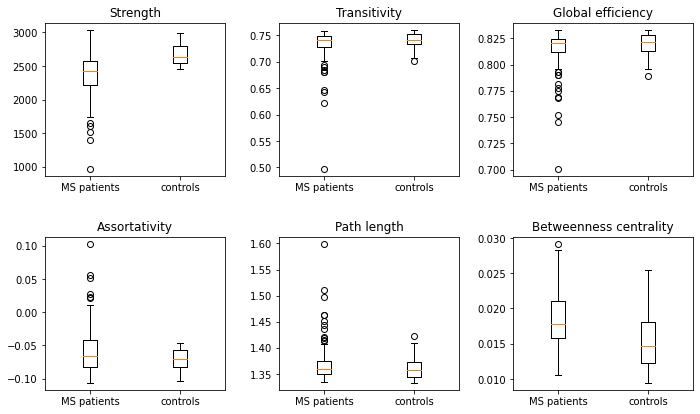

In [20]:
fig, axs = plt.subplots(2, 3,figsize=(10, 6))

plot_metric_boxplot(patients_FA_metrics,controls_FA_metrics,'Strength', [0,0])
plot_metric_boxplot(patients_FA_metrics,controls_FA_metrics,'Transitivity', [0,1])
plot_metric_boxplot(patients_FA_metrics,controls_FA_metrics,'Global efficiency', [0,2])
plot_metric_boxplot(patients_FA_metrics,controls_FA_metrics,'Assortativity', [1,0])
plot_metric_boxplot(patients_FA_metrics,controls_FA_metrics,'Path length', [1,1])
plot_metric_boxplot(patients_FA_metrics,controls_FA_metrics,'Betweenness centrality', [1,2])


fig.subplots_adjust(left=0.08, right=0.98, bottom=0.05, top=0.9,
                    hspace=0.4, wspace=0.3)

In [21]:
data = global_metrics_summary(patients_FA_metrics,controls_FA_metrics,cmetrics, alternative='less')
print(tabulate(data, headers=["Metric", "MS Patients", "Controls", "pvalue"]))

Metric                  MS Patients        Controls                pvalue
----------------------  -----------------  -----------------  -----------
Strength                (2376.08, 312.17)  (2681.23, 165.04)  7.61848e-06
Transitivity            (0.73, 0.03)       (0.74, 0.02)       0.117198
Global efficiency       (0.82, 0.02)       (0.82, 0.01)       0.185712
Assortativity           (-0.06, 0.03)      (-0.07, 0.02)      0.895634
Path length             (1.37, 0.04)       (1.36, 0.02)       0.812189
Betweenness centrality  (0.02, 0.0)        (0.02, 0.0)        0.994977


In [22]:
bonferroni_correction(data)
print(tabulate(data, headers=["Metric", "MS Patients", "Controls", "pvalue"]))

Metric                  MS Patients        Controls           pvalue
----------------------  -----------------  -----------------  -------------------------
Strength                (2376.08, 312.17)  (2681.23, 165.04)  4.571089942892765e-05 (*)
Transitivity            (0.73, 0.03)       (0.74, 0.02)       0.7031858268031856
Global efficiency       (0.82, 0.02)       (0.82, 0.01)       1.0
Assortativity           (-0.06, 0.03)      (-0.07, 0.02)      1.0
Path length             (1.37, 0.04)       (1.36, 0.02)       1.0
Betweenness centrality  (0.02, 0.0)        (0.02, 0.0)        1.0


In [23]:
data = global_metrics_summary(patients_FA_metrics,controls_FA_metrics,cmetrics, alternative='greater')
print(tabulate(data, headers=["Metric", "MS Patients", "Controls", "pvalue"]))

Metric                  MS Patients        Controls              pvalue
----------------------  -----------------  -----------------  ---------
Strength                (2376.08, 312.17)  (2681.23, 165.04)  0.999993
Transitivity            (0.73, 0.03)       (0.74, 0.02)       0.883827
Global efficiency       (0.82, 0.02)       (0.82, 0.01)       0.815683
Assortativity           (-0.06, 0.03)      (-0.07, 0.02)      0.105315
Path length             (1.37, 0.04)       (1.36, 0.02)       0.189222
Betweenness centrality  (0.02, 0.0)        (0.02, 0.0)        0.0050995


In [24]:
bonferroni_correction(data)
print(tabulate(data, headers=["Metric", "MS Patients", "Controls", "pvalue"]))

Metric                  MS Patients        Controls           pvalue
----------------------  -----------------  -----------------  ------------------------
Strength                (2376.08, 312.17)  (2681.23, 165.04)  1.0
Transitivity            (0.73, 0.03)       (0.74, 0.02)       1.0
Global efficiency       (0.82, 0.02)       (0.82, 0.01)       1.0
Assortativity           (-0.06, 0.03)      (-0.07, 0.02)      0.6318897070042017
Path length             (1.37, 0.04)       (1.36, 0.02)       1.0
Betweenness centrality  (0.02, 0.0)        (0.02, 0.0)        0.030597023245875276 (*)


Se observa en pacientes, por lo tanto, una disminución del strength y un aumento del betweness centrality (p<0.05, bonferroni)

### 4.2.2. Conectividad morfológica

In [25]:
# Listados de matrices de conectividad estructural para cada uno de los grupos
patients_GM = [patients[s]['GM'] for s in patients.keys()]
controls_GM = [controls[s]['GM'] for s in controls.keys()]

In [26]:
# Cálculo de métricas de grafos globales
patients_GM_metrics = graph_global_metrics(patients_GM)
controls_GM_metrics = graph_global_metrics(controls_GM)
cmetrics            = patients_GM_metrics.keys()

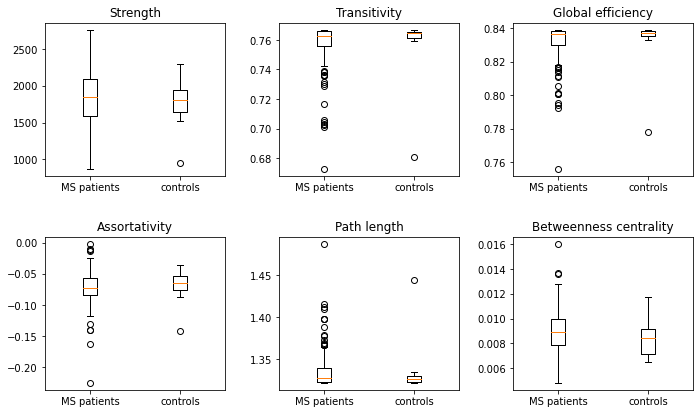

In [27]:
fig, axs = plt.subplots(2, 3,figsize=(10, 6))

plot_metric_boxplot(patients_GM_metrics,controls_GM_metrics,'Strength', [0,0])
plot_metric_boxplot(patients_GM_metrics,controls_GM_metrics,'Transitivity', [0,1])
plot_metric_boxplot(patients_GM_metrics,controls_GM_metrics,'Global efficiency', [0,2])
plot_metric_boxplot(patients_GM_metrics,controls_GM_metrics,'Assortativity', [1,0])
plot_metric_boxplot(patients_GM_metrics,controls_GM_metrics,'Path length', [1,1])
plot_metric_boxplot(patients_GM_metrics,controls_GM_metrics,'Betweenness centrality', [1,2])


fig.subplots_adjust(left=0.08, right=0.98, bottom=0.05, top=0.9,
                    hspace=0.4, wspace=0.3)

In [28]:
data = global_metrics_summary(patients_GM_metrics,controls_GM_metrics,cmetrics, alternative = 'less')
print(tabulate(data, headers=["Metric", "MS Patients", "Controls", "pvalue"]))

Metric                  MS Patients        Controls              pvalue
----------------------  -----------------  -----------------  ---------
Strength                (1832.51, 359.97)  (1792.07, 284.52)  0.657292
Transitivity            (0.76, 0.02)       (0.76, 0.02)       0.154417
Global efficiency       (0.83, 0.01)       (0.83, 0.01)       0.167114
Assortativity           (-0.07, 0.03)      (-0.07, 0.02)      0.0874903
Path length             (1.34, 0.02)       (1.33, 0.03)       0.834193
Betweenness centrality  (0.01, 0.0)        (0.01, 0.0)        0.889353


In [29]:
bonferroni_correction(data)
print(tabulate(data, headers=["Metric", "MS Patients", "Controls", "pvalue"]))

Metric                  MS Patients        Controls             pvalue
----------------------  -----------------  -----------------  --------
Strength                (1832.51, 359.97)  (1792.07, 284.52)  1
Transitivity            (0.76, 0.02)       (0.76, 0.02)       0.9265
Global efficiency       (0.83, 0.01)       (0.83, 0.01)       1
Assortativity           (-0.07, 0.03)      (-0.07, 0.02)      0.524942
Path length             (1.34, 0.02)       (1.33, 0.03)       1
Betweenness centrality  (0.01, 0.0)        (0.01, 0.0)        1


In [30]:
data = global_metrics_summary(patients_GM_metrics,controls_GM_metrics,cmetrics, alternative = 'greater')
print(tabulate(data, headers=["Metric", "MS Patients", "Controls", "pvalue"]))

Metric                  MS Patients        Controls             pvalue
----------------------  -----------------  -----------------  --------
Strength                (1832.51, 359.97)  (1792.07, 284.52)  0.344631
Transitivity            (0.76, 0.02)       (0.76, 0.02)       0.846824
Global efficiency       (0.83, 0.01)       (0.83, 0.01)       0.834193
Assortativity           (-0.07, 0.03)      (-0.07, 0.02)      0.913338
Path length             (1.34, 0.02)       (1.33, 0.03)       0.167114
Betweenness centrality  (0.01, 0.0)        (0.01, 0.0)        0.111637


In [31]:
bonferroni_correction(data)
print(tabulate(data, headers=["Metric", "MS Patients", "Controls", "pvalue"]))

Metric                  MS Patients        Controls             pvalue
----------------------  -----------------  -----------------  --------
Strength                (1832.51, 359.97)  (1792.07, 284.52)  1
Transitivity            (0.76, 0.02)       (0.76, 0.02)       1
Global efficiency       (0.83, 0.01)       (0.83, 0.01)       1
Assortativity           (-0.07, 0.03)      (-0.07, 0.02)      1
Path length             (1.34, 0.02)       (1.33, 0.03)       1
Betweenness centrality  (0.01, 0.0)        (0.01, 0.0)        0.669823


No se observan diferencias significativas

### 4.2.3. Conectividad funcional

In [32]:
# Listados de matrices de conectividad estructural para cada uno de los grupos
patients_rfMRI = [patients[s]['rfMRI'] for s in patients.keys()]
controls_rfMRI = [controls[s]['rfMRI'] for s in controls.keys()]

In [33]:
# Cálculo de métricas de grafos globales
patients_rfMRI_metrics = graph_global_metrics(patients_rfMRI)
controls_rfMRI_metrics = graph_global_metrics(controls_rfMRI)
cmetrics               = patients_rfMRI_metrics.keys()

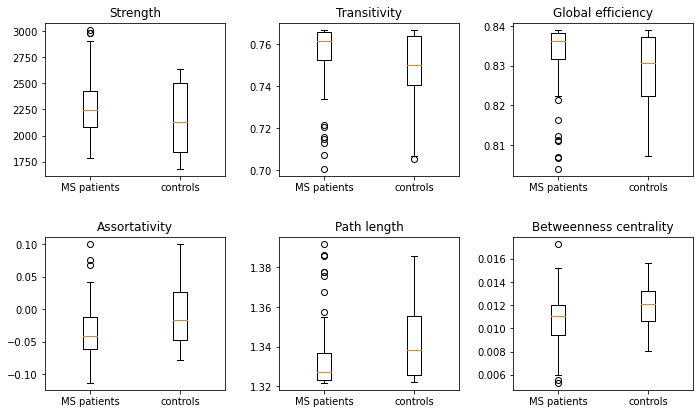

In [34]:
fig, axs = plt.subplots(2, 3,figsize=(10, 6))

plot_metric_boxplot(patients_rfMRI_metrics,controls_rfMRI_metrics,'Strength', [0,0])
plot_metric_boxplot(patients_rfMRI_metrics,controls_rfMRI_metrics,'Transitivity', [0,1])
plot_metric_boxplot(patients_rfMRI_metrics,controls_rfMRI_metrics,'Global efficiency', [0,2])
plot_metric_boxplot(patients_rfMRI_metrics,controls_rfMRI_metrics,'Assortativity', [1,0])
plot_metric_boxplot(patients_rfMRI_metrics,controls_rfMRI_metrics,'Path length', [1,1])
plot_metric_boxplot(patients_rfMRI_metrics,controls_rfMRI_metrics,'Betweenness centrality', [1,2])


fig.subplots_adjust(left=0.08, right=0.98, bottom=0.05, top=0.9,
                    hspace=0.4, wspace=0.3)

In [35]:
data = global_metrics_summary(patients_rfMRI_metrics,controls_rfMRI_metrics,cmetrics,alternative='less')
print(tabulate(data, headers=["Metric", "MS Patients", "Controls", "pvalue"]))

Metric                  MS Patients        Controls              pvalue
----------------------  -----------------  -----------------  ---------
Strength                (2278.51, 264.31)  (2148.51, 328.14)  0.950434
Transitivity            (0.76, 0.01)       (0.75, 0.02)       0.987449
Global efficiency       (0.83, 0.01)       (0.83, 0.01)       0.987578
Assortativity           (-0.04, 0.04)      (-0.01, 0.05)      0.0181585
Path length             (1.33, 0.01)       (1.34, 0.02)       0.0123374
Betweenness centrality  (0.01, 0.0)        (0.01, 0.0)        0.0188689


In [36]:
bonferroni_correction(data)
print(tabulate(data, headers=["Metric", "MS Patients", "Controls", "pvalue"]))

Metric                  MS Patients        Controls              pvalue
----------------------  -----------------  -----------------  ---------
Strength                (2278.51, 264.31)  (2148.51, 328.14)  1
Transitivity            (0.76, 0.01)       (0.75, 0.02)       1
Global efficiency       (0.83, 0.01)       (0.83, 0.01)       1
Assortativity           (-0.04, 0.04)      (-0.01, 0.05)      0.108951
Path length             (1.33, 0.01)       (1.34, 0.02)       0.0740244
Betweenness centrality  (0.01, 0.0)        (0.01, 0.0)        0.113214


In [37]:
data = global_metrics_summary(patients_rfMRI_metrics,controls_rfMRI_metrics,cmetrics,alternative='greater')
print(tabulate(data, headers=["Metric", "MS Patients", "Controls", "pvalue"]))

Metric                  MS Patients        Controls              pvalue
----------------------  -----------------  -----------------  ---------
Strength                (2278.51, 264.31)  (2148.51, 328.14)  0.0501035
Transitivity            (0.76, 0.01)       (0.75, 0.02)       0.0127214
Global efficiency       (0.83, 0.01)       (0.83, 0.01)       0.0125911
Assortativity           (-0.04, 0.04)      (-0.01, 0.05)      0.982073
Path length             (1.33, 0.01)       (1.34, 0.02)       0.987829
Betweenness centrality  (0.01, 0.0)        (0.01, 0.0)        0.981371


In [38]:
bonferroni_correction(data)
print(tabulate(data, headers=["Metric", "MS Patients", "Controls", "pvalue"]))

Metric                  MS Patients        Controls              pvalue
----------------------  -----------------  -----------------  ---------
Strength                (2278.51, 264.31)  (2148.51, 328.14)  0.300621
Transitivity            (0.76, 0.01)       (0.75, 0.02)       0.0763285
Global efficiency       (0.83, 0.01)       (0.83, 0.01)       0.0755467
Assortativity           (-0.04, 0.04)      (-0.01, 0.05)      1
Path length             (1.33, 0.01)       (1.34, 0.02)       1
Betweenness centrality  (0.01, 0.0)        (0.01, 0.0)        1


No se observan diferencias significativas

## 4.3. Métricas locales

### 4.3.1. Nodos

En este apartado, se calcula para cada uno de los nodos (solo para las conectividades estructurales, que son las que han presentado diferencias significativas en las métricas globales) sus grados medios (ponderados por peso) y el betweness centrality en cada uno de los grafos.

Posteriormente, se comparan los listados obtenidos para cada uno de los grupos (pacientes y controles) para ver si existen diferencias significativas, y se obtiene el número de nodos que muestran estas diferencias. Para ello, empleamos el test U de Mann-Whitney con corrección de Bonferroni.

Finalmente, se estudia qué nodos pueden ser considerados hubs. Para ello, los nodos que muestran una mayor strength media (> mean + 1std) se consideran hubs.

In [39]:
def graph_local_metrics(graph_list, nodes):
    '''
    Dada una lista de grafos, esta función retorna, para cada uno de ellos las siguientes
    métricas: strength, transitivity, global efficiency, assortativity, clustering coefficient,
    betwenness centrality
    '''
    cmetrics = dict.fromkeys(nodes)

    for node in nodes:
        cmetrics[node] = {}
        cmetrics[node]['Strength']                = [G.degree(weight = 'weight')[node] if node in G.nodes 
                                                     else 0 for G in graph_list ]
        cmetrics[node]['Betweness centrality']    = [nx.betweenness_centrality(G,weight = 'weight')[node] if node in G.nodes 
                                                     else 0 for G in graph_list ]
        cmetrics[node]['Average strength']        = np.mean([G.degree(weight = 'weight')[node] if node in G.nodes 
                                                             else 0 for G in graph_list])
 
    # Retornamos los resultados
    return cmetrics

def global_local_summary(patients_metrics,controls_metrics, alternative='two-sided'):
    '''
    Retorna una tabla con el resumen de las métricas de los nodos para ambos grupos de sujetos
    y el pvalor correspondiente
    '''
    data=[]
    
    for node in nodes:
        pvaluelist = []
        row = [node]
        
        # Comparamos las métricas entre los sujetos sanos y pacientes
        for metric in ['Strength','Betweness centrality']:

            patients_stats = (np.mean(patients_metrics[node][metric]) .round(2),
                              np.std (patients_metrics[node][metric]) .round(2))
            controls_stats = (np.mean(controls_metrics[node][metric]) .round(2),
                              np.std (controls_metrics[node][metric]) .round(2))
            pvalue = mannwhitneyu(patients_metrics[node][metric], controls_metrics[node][metric],
                                  alternative='less').pvalue 
            pvaluelist.append(pvalue)
        
        # Aplicamos la corrección de bonferroni por nodo
        adjusted_pvals = list(multipletests(pvaluelist, method='bonferroni',is_sorted=False,returnsorted=False)[1])
        
        # Reemplazamos los pvalores por los pvalores ajustados
        for i in [0,1]:
            row.append(str(adjusted_pvals[i])+ ' (*)' if adjusted_pvals[i] <0.05 else adjusted_pvals[i])
            
        data.append(row)
        
    return data

def hubs(metrics):
    '''
    Nodes showing higher strength (above 1 standard deviation, SD, of the mean strength 
    of all nodes in each group of participants) were considered hubs of the network 
    '''
    all_avg_strengths = [metrics[node]['Average strength'] for node in metrics]
    global_mean1std = np.mean(all_avg_strengths)+np.std(all_avg_strengths) 

    hubs = [node for node in metrics if metrics[node]['Average strength'] >= global_mean1std ]
    
    return hubs


def edge_FA(graph_list,edge_list):
    
    FA = dict.fromkeys(edge_list)

    for edge in edge_list:
        edge_FA = []
        for G in graph_list:
            try:
                edge_FA.append(G[edge[0]][edge[1]]["weight"])
            except:
                edge_FA.append(0)

        FA[edge] = edge_FA
        
    return FA       

#### 4.3.1.1. Conectividad estructural

In [40]:
patients_FA_node_metrics = graph_local_metrics(patients_FA, nodes)
controls_FA_node_metrics = graph_local_metrics(controls_FA, nodes)

In [41]:
data = global_local_summary(patients_FA_node_metrics,controls_FA_node_metrics)
print(tabulate(data, headers=["Node", "Strength - pvalue", "Betweness centrality - pvalue"]))

Node                             Strength - pvalue           Betweness centrality - pvalue
-------------------------------  --------------------------  -------------------------------
ctx-lh-caudalanteriorcingulate   0.005830337569399622 (*)    0.05916260205130043
ctx-lh-caudalmiddlefrontal       0.004283613311507435 (*)    0.88016860431816
ctx-lh-cuneus                    1.2898342610678088e-05 (*)  1.0
ctx-lh-entorhinal                0.0035685304300616554 (*)   1.0
ctx-lh-fusiform                  0.0006239452044642615 (*)   1.0
ctx-lh-inferiorparietal          0.0008618419735086011 (*)   1.0
ctx-lh-inferiortemporal          0.0003010668989717804 (*)   1.0
ctx-lh-isthmuscingulate          0.00023111236046170476 (*)  0.3040671183545348
ctx-lh-lateraloccipital          0.00010183506265750698 (*)  1.0
ctx-lh-lateralorbitofrontal      0.002453883273922623 (*)    1.0
ctx-lh-lingual                   1.7149294525020286e-05 (*)  1.0
ctx-lh-medialorbitofrontal       0.006019451183641712 (*)

In [42]:
colors = {}

for (n,p1,p2) in data:
    if('*' in str(p1)):
        colors[n]='red'
    else:   
        colors[n]='grey'

# Número de nodos que presentan diferencias significativas        
signif_decreased_strength_nodes = len([c for c in colors.values() if c=='red'])
signif_decreased_strength_nodes

73

In [43]:
# hubs para pacientes
hubs(patients_FA_node_metrics)

['ctx-lh-inferiorparietal',
 'ctx-lh-precuneus',
 'ctx-lh-superiorparietal',
 'ctx-lh-insula',
 'Left-Thalamus-Proper',
 'Left-Putamen',
 'Left-Pallidum',
 'Right-Thalamus-Proper',
 'Right-Putamen',
 'Right-Pallidum',
 'ctx-rh-inferiorparietal',
 'ctx-rh-middletemporal',
 'ctx-rh-precuneus',
 'ctx-rh-superiorparietal',
 'ctx-rh-superiortemporal',
 'ctx-rh-insula']

In [44]:
# Hubs para controles
hubs(controls_FA_node_metrics)

['ctx-lh-inferiorparietal',
 'ctx-lh-precuneus',
 'ctx-lh-superiorparietal',
 'ctx-lh-insula',
 'Left-Thalamus-Proper',
 'Left-Putamen',
 'Right-Thalamus-Proper',
 'Right-Putamen',
 'Right-Pallidum',
 'ctx-rh-inferiorparietal',
 'ctx-rh-middletemporal',
 'ctx-rh-precuneus',
 'ctx-rh-superiorparietal',
 'ctx-rh-superiortemporal',
 'ctx-rh-insula']

In [45]:
# Hubs en pacientes que no aparecen en controles
[h for h in hubs(patients_FA_node_metrics) if h not in hubs(controls_FA_node_metrics)]

['Left-Pallidum']

### 4.3.2. Enlaces

En este apartado, se compara el listado de pesos FA de cada uno de los enlaces de entre grupos de sujetos. Esto nos devuelve un número de enlaces que presentan diferencias significativas.

Se aprovecha este proceso para etiquetas cada uno de estos enlaces como ‘red’/’blue’ en función de si los pacientes presentan una disminución/aumento significativo de los pesos con respecto a los sujetos sanos. Esto se utilizará más adelante para la representación y visualización del conectograma.

In [47]:
# function to calculate Cohen's d for independent samples
def cohend_test(d1, d2):
    # calculate the size of samples
    n1, n2 = len(d1), len(d2)
    # calculate the variance of the samples
    s1, s2 = np.var(d1, ddof=1), np.var(d2, ddof=1)
    # calculate the pooled standard deviation
    s = np.sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
    # calculate the means of the samples
    u1, u2 = np.mean(d1), np.mean(d2)
    # calculate the effect size
    return (u1 - u2) / s

In [48]:
patients_FA_edge_metric = edge_FA(patients_FA,edges)
controls_FA_edge_metric = edge_FA(controls_FA,edges)

edge_colors = {}

for edge in edges:
    pval1 = mannwhitneyu(patients_FA_edge_metric[edge], controls_FA_edge_metric[edge],alternative='less').pvalue
    pval2 = mannwhitneyu(patients_FA_edge_metric[edge], controls_FA_edge_metric[edge],alternative='greater').pvalue
    cohend = cohend_test(patients_FA_edge_metric[edge], controls_FA_edge_metric[edge]);  
    if(pval1<0.05 and cohend>0):
        edge_colors[edge]='red'
    if(pval2<0.05 and cohend>0):
        edge_colors[edge]='blue'   

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_15960/1699558836.py:12: RuntimeWarning: invalid value encountered in scalar divide
  return (u1 - u2) / s


In [49]:
# númreo de enlaces que presentan diferencias significativaas
len(edge_colors)

25

## 5. Clasificación

En este apartado, se lleva a cabo la creación de un modelo de predicción SVM que diferencie sujetos sanos de sujetos con EM basándose en las diferentes métricas que hemos calculado a lo largo del estudio. Para ello, se probarán los siguientes modelos:

- SVM basado en la transividad
- SVM basado la eficiencia global
- SVM basado en la variable obtenida como componente principal (PCA) considerando todas las métricas

In [75]:
def SVM_pred (x, y):
    
    # Split dataset into training set and test set
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state = 5) # 70% training and 30% test

    #Create a svm Classifier
    clf = svm.SVC(class_weight='balanced') 

    #Train the model using the training sets
    clf.fit(np.array(X_train).reshape(-1, 1), y_train)

    #Predict the response for test dataset
    y_pred = clf.predict(np.array(X_test).reshape(-1, 1))
    
    return y_test, y_pred
    
    
def mostrar_resultados(y_test, pred_y):
    conf_matrix = metrics.confusion_matrix(y_test, pred_y)
    plt.figure(figsize=(5, 5))
    sns.heatmap(conf_matrix, xticklabels=['Normal','Fraudulent'], yticklabels=['Normal','Fraudulent'], annot=True, fmt="d");
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()
    print (metrics.classification_report(y_test, pred_y))

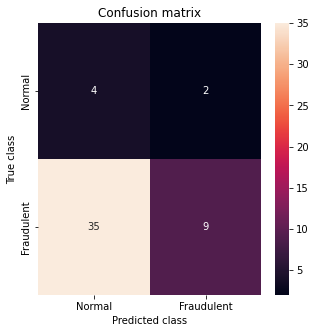

              precision    recall  f1-score   support

           0       0.10      0.67      0.18         6
           1       0.82      0.20      0.33        44

    accuracy                           0.26        50
   macro avg       0.46      0.44      0.25        50
weighted avg       0.73      0.26      0.31        50



In [76]:
# Prediction based on grph transitivity
x = []
y = []

for p in patients: 
    x.append(nx.transitivity(patients[p]['FA']))
    y.append(list(clinic[clinic.id==p]['controls_ms'])[0])
    
for p in controls: 
    x.append(nx.transitivity(controls[p]['FA']))
    y.append(list(clinic[clinic.id==p]['controls_ms'])[0])   
    
y_test, y_pred = SVM_pred (x, y)
mostrar_resultados(y_test, y_pred)

In [77]:
scores = cross_val_score(svm.SVC(class_weight='balanced'), np.array(x).reshape(-1, 1), y, cv=10)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.62 accuracy with a standard deviation of 0.17


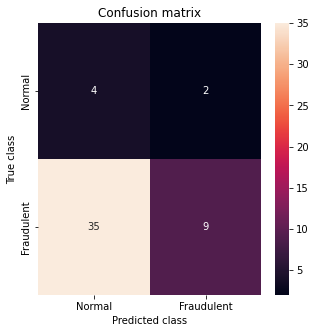

              precision    recall  f1-score   support

           0       0.10      0.67      0.18         6
           1       0.82      0.20      0.33        44

    accuracy                           0.26        50
   macro avg       0.46      0.44      0.25        50
weighted avg       0.73      0.26      0.31        50



In [78]:
# Prediction based on global_efficiency
x = []
y = []

for p in patients: 
    x.append(nx.global_efficiency(patients[p]['FA']))
    y.append(list(clinic[clinic.id==p]['controls_ms'])[0])
    
for p in controls: 
    x.append(nx.global_efficiency(controls[p]['FA']))
    y.append(list(clinic[clinic.id==p]['controls_ms'])[0])    
    
y_test, y_pred = SVM_pred (x, y)
mostrar_resultados(y_test, y_pred)

In [79]:
scores = cross_val_score(svm.SVC(class_weight='balanced'), np.array(x).reshape(-1, 1), y, cv=10)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.74 accuracy with a standard deviation of 0.11


In [80]:
# Recopilamos todas las métricas 
data1 = pd.DataFrame(patients_FA_metrics)
data2 = pd.DataFrame(controls_FA_metrics)

# Diferenciamos sujetos sanos y pacientes
data1['y']=1
data2['y']=0

# Unificamos todo en un mismo dataset
data = pd.concat([data1,data2])

In [81]:
# Aplicaremos PCA components para resumir todas las métricas en una sola columna

y = data['y']
x = data[['Strength','Transitivity','Global efficiency','Assortativity','Path length','Betweenness centrality']]
x_scaled = StandardScaler().fit_transform(x)
 
pca = PCA(n_components=1)
 
pca_features = pca.fit_transform(x_scaled)
 
print('Shape before PCA: ', x_scaled.shape)
print('Shape after PCA: ', pca_features.shape)
 
pca_df = pd.DataFrame(
    data=pca_features, 
    columns=['PC1'])

pca_df

Shape before PCA:  (165, 6)
Shape after PCA:  (165, 1)


,PC1
0,-0.520983
1,-0.221827
2,-1.320674
3,-0.613773
4,-0.702186
...,...
160,-0.727824
161,-0.991962
162,-0.401565
163,1.463289


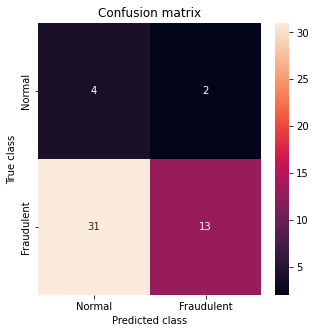

              precision    recall  f1-score   support

           0       0.11      0.67      0.20         6
           1       0.87      0.30      0.44        44

    accuracy                           0.34        50
   macro avg       0.49      0.48      0.32        50
weighted avg       0.78      0.34      0.41        50



In [82]:
y_test, y_pred = SVM_pred (pca_df, y)
mostrar_resultados(y_test, y_pred)

In [83]:
scores = cross_val_score(svm.SVC(class_weight='balanced'), pca_df, y, cv=10)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.60 accuracy with a standard deviation of 0.18


## 6. Visualización


En este apartado, se presenta un conectograma donde podemos visualizar los enlaces que presentan diferencias significativas (p<0.05) con un effect size mayor de cero. Estos enlaces se muestran en color rojo si el FA es menor para los suejetos pacientes en comparación con los sujetos sanos; en color azul en caso contrario. Los nodos (regiones cerebrales), presentados a lo largo del círculo del conectograma, se muestran en rojo si los pacientes presentan un nodal strength significativamente diferente (pval<0.05, bonferroni) en comparación con los sujetos sanos.

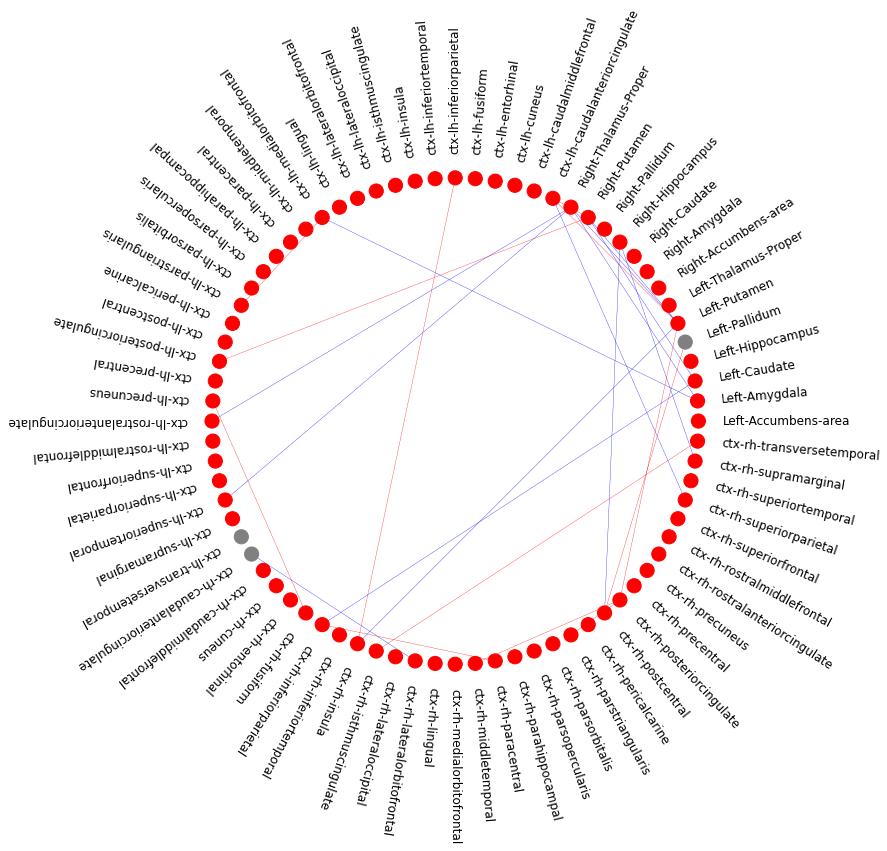

In [84]:
G=nx.Graph()
G.add_nodes_from(colors.keys())
node_colors = colors.values()
edges_list = edge_colors.keys()
G.add_edges_from(edges_list)
edge_colors2 = [edge_colors[(u,v)] for u,v in edge_colors]
labels={}


node_list = sorted(G.nodes())
n= len(G.nodes())
angle = []
angle_dict = {}
for i, node in zip(range(n),node_list):
    theta = 2.0*np.pi*i/n
    angle.append((np.cos(theta),np.sin(theta)))
    angle_dict[node] = theta
pos = {}
for node_i, node in enumerate(node_list):
    pos[node] = angle[node_i]

for node in G.nodes:
    labels[node]=str(node)
    
# figsize is intentionally set small to condense the graph
fig, ax = plt.subplots(figsize=(24,24))
margin=0.33
fig.subplots_adjust(margin, margin, 1.-margin, 1.-margin)
ax.axis('equal')

nx.draw(G,pos=pos,with_labels=False, ax=ax, node_size=200, 
        node_color = node_colors, edge_color = edge_colors2,
        width=0.3)
description = nx.draw_networkx_labels(G,pos,labels=labels)

r = fig.canvas.get_renderer()
trans = plt.gca().transData.inverted()
for node, t in description.items():
    bb = t.get_window_extent(renderer=r)
    bbdata = bb.transformed(trans)
    radius = 1.1+(bbdata.width)/2.
    position = (radius*np.cos(angle_dict[node]),radius* np.sin(angle_dict[node]))
    t.set_position(position)
    t.set_rotation(angle_dict[node]*360.0/(2.0*np.pi))
    t.set_clip_on(False)


plt.show()